In [42]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
R-peak validation pipeline (clean version)
-----------------------------------------
This script consolidates the essential pieces to:
  1) Load ECG from TDMS
  2) Parse LabVIEW RR (.lvm) with comma or dot decimals
  3) (Optionally) normalize/convert timestamps using Arrow + IANA tz
  4) Detect ECG R-peaks (NeuroKit2) and align with LabVIEW R-peaks
  5) Create binary peak trains (0/1), zero-pad as needed to overlay
  6) Compute metrics with lag & tolerance (TP/FP/FN/Sensitivity/PPV/F1)
  7) Plot a quick comparison window

Fill in the PATH variables in __main__ and run.
Requires: pandas, numpy, neurokit2, nptdms, arrow, scipy, matplotlib
"""

from __future__ import annotations
import os
import re
import numpy as np
import pandas as pd
import arrow
import nptdms
from datetime import datetime, date, time
from typing import Tuple, Dict, Iterable, Optional

import neurokit2 as nk
from scipy.signal import correlate, convolve
import matplotlib.pyplot as plt



In [43]:

# -----------------------------
#         I/O helpers
# -----------------------------

def read_labview_rr(path: str, skiprows: int = 22) -> np.ndarray:
    """
    Read RR intervals (seconds) from LabVIEW .lvm (or text) file.

    - Handles tab-separated with decimal comma (classic LVM) or autodetected separators.
    - Picks the most plausible RR column (median ~0.2–3 s).
    - Converts from ms/us if needed.
    """
    try:
        df = pd.read_csv(path, sep="\t", engine="python", skiprows=skiprows, header=0, decimal=",")
    except Exception:
        df = pd.read_csv(path, sep=None, engine="python", skiprows=skiprows, header=0)
        # force comma -> dot numeric
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", "."), errors="coerce"))

    # choose the RR column
    cols = [c for c in df.columns if str(c).lower() not in ("x_value", "xvalue", "comment")]
    rr = None
    if "Untitled" in df.columns:
        rr = pd.to_numeric(df["Untitled"], errors="coerce").dropna().to_numpy(float)

    if rr is None:
        for c in cols:
            v = pd.to_numeric(df[c], errors="coerce").dropna().to_numpy(float)
            if v.size:
                med = float(np.nanmedian(v))
                if 0.1 < med < 5.0:  # seconds
                    rr = v
                    break
        if rr is None and cols:
            rr = pd.to_numeric(df[cols[0]], errors="coerce").dropna().to_numpy(float)

    if rr is None or rr.size == 0:
        raise ValueError("Could not find an RR column in the provided LabVIEW file.")

    # unit normalization
    med = float(np.nanmedian(rr))
    if med > 10000:  # microseconds
        rr = rr / 1_000_000.0
    elif med > 5:    # milliseconds
        rr = rr / 1_000.0
    return rr


def rr_to_peak_samples(rr_seconds: Iterable[float], fs: float, t0_s: float = 0.0) -> np.ndarray:
    """
    Convert RR (sec) to absolute peak sample indices (int), assuming first peak at t0_s.

    peak_times = [t0, t0 + rr[0], t0 + rr[0]+rr[1], ...]
    sample_idx = round(peak_times * fs)
    """
    rr = np.asarray(rr_seconds, dtype=float).ravel()
    t_peaks = t0_s + np.cumsum(np.insert(rr, 0, 0.0))
    return np.rint(t_peaks * fs).astype(np.int64)


def make_binary_series(peak_samples: np.ndarray, n_samples: Optional[int], left_pad: int = 0, right_pad: int = 0) -> np.ndarray:
    """
    Create a binary series with ones at peak positions, with optional left/right zero-padding.
    If n_samples is None: length will be max(peak)+1 plus padding.
    Negative peaks are ignored; peaks >= length are dropped.
    """
    peaks = np.asarray(peak_samples, dtype=int)
    if n_samples is None:
        length = (int(peaks.max()) + 1 if peaks.size else 0) + left_pad + right_pad
    else:
        length = int(n_samples) + left_pad + right_pad

    x = np.zeros(length, dtype=np.uint8)
    # shift peaks by left_pad for insertion
    shifted = peaks + left_pad
    valid = shifted[(shifted >= 0) & (shifted < length)]
    x[valid] = 1
    return x


# -----------------------------
#   Time parsing & alignment
# -----------------------------

def read_header_datetime_lvm(path: str, default_date_fmt: str = "%Y/%m/%d") -> Optional[datetime]:
    """
    Parse 'Date' and 'Time' from a LabVIEW .lvm header before ***End_of_Header***.
    Returns a naive datetime (no tz) if found; otherwise None.

    'Time' examples: '13:06:19,1816539465369...' or '13:06:19.1816...' or '13:06:19'.
    """
    date_val = None
    time_val = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            ls = line.strip()
            if ls.startswith("***End_of_Header***"):
                break
            low = ls.lower()
            if low.startswith("date\t") and date_val is None:
                date_val = ls.split("\t", 1)[1].strip()
            elif "time" in low and "time_pref" not in low and low.startswith("time\t") and time_val is None:
                time_val = ls.split("\t", 1)[1].strip()

    if not time_val:
        return None

    m = re.match(r"^(\d{2}:\d{2}:\d{2})[,.](\d+)$", time_val)
    if m:
        hhmmss, frac = m.group(1), m.group(2)
        # normalize to microseconds with rounding on the 7th digit
        if len(frac) > 6 and int(frac[6]) >= 5:
            frac6 = str(int(frac[:6]) + 1).zfill(6)
        else:
            frac6 = frac[:6].ljust(6, "0")
        time_norm = f"{hhmmss}.{frac6}"
        t_dt = datetime.strptime(time_norm, "%H:%M:%S.%f")
    else:
        # HH:MM:SS only
        m2 = re.match(r"^\d{2}:\d{2}:\d{2}$", time_val)
        if not m2:
            return None
        t_dt = datetime.strptime(time_val, "%H:%M:%S")

    if date_val:
        fmts = [default_date_fmt, "%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y"]
        for fmt in fmts:
            try:
                d = datetime.strptime(date_val, fmt).date()
                return datetime.combine(d, t_dt.time())
            except ValueError:
                continue
        # fallback to time only
        return t_dt
    return t_dt

import arrow
import pandas as pd
from datetime import datetime
from typing import Optional, Tuple
import numpy as np
import nptdms
import arrow
import pandas as pd
from datetime import datetime
from typing import Optional

# ---------- Time helpers (returner Python datetime, ikke Arrow) ----------


def to_local_datetime(
    v,
    assume_tz: str = "UTC",
    out_tz: str = "Europe/Copenhagen",
    naive: bool = True,
) -> Optional[datetime]:
    """
    Konverter v (string/np.datetime64/datetime/Arrow) til Python datetime i ønsket tidszone.
    - DST håndteres internt af Arrow.
    - naive=True => tz-naiv datetime i out_tz
    - naive=False => tz-aware datetime i out_tz
    """
    try:
        a = arrow.get(pd.to_datetime(v))
        if a.tzinfo is None:
            a = a.replace(tzinfo=assume_tz)
        a = a.to(out_tz)
        return a.naive if naive else a.datetime
    except Exception:
        return None

def _dt_from_any(
    v,
    assume_tz: str = "UTC",
    out_tz: Optional[str] = "Europe/Copenhagen",
    naive: bool = True,
) -> Optional[datetime]:
    """
    Parse TDMS timestamp -> Python datetime.
    * Arrow bruges kun internt til tz/DST; der returneres en datetime.
    * assume_tz: tz der påsættes, hvis kilden er tz-naiv.
    * out_tz: mål-tidszone (None => behold original tz).
    * naive=True returnerer tz-naiv datetime (i out_tz); naive=False returnerer tz-aware.
    """
    try:
        a = arrow.get(pd.to_datetime(v))
        if a.tzinfo is None:
            a = a.replace(tzinfo=assume_tz)
        if out_tz:
            a = a.to(out_tz)
        return a.naive if naive else a.datetime
    except Exception:
        return None

def _find_time_in_props_dt(props: dict,
                           assume_tz="UTC",
                           out_tz="Europe/Copenhagen",
                           naive=True) -> Optional[datetime]:
    if not isinstance(props, dict):
        return None
    keys = (
        "wf_start_time",
        "ni_expstarttimestamp",
        "ni_exptimestamp",
        "wf_start",
        "start_time",
        "time",  # bred fallback
    )
    for k, v in props.items():
        kl = str(k).lower()
        if any(tag in kl for tag in keys) and v is not None:
            dt = _dt_from_any(v, assume_tz=assume_tz, out_tz=out_tz, naive=naive)
            if dt is not None:
                return dt
    return None

def _extract_fs_from_props(props: dict, default_fs=512.0) -> float:
    if not isinstance(props, dict):
        return float(default_fs)
    for key in ("wf_increment", "increment", "dt"):
        if key in props and props[key] not in (None, ""):
            try:
                inc = float(props[key])
                if inc > 0:
                    return 1.0 / inc
            except Exception:
                pass
    for key in ("wf_sample_rate", "sample_rate", "sampling_rate", "rate"):
        if key in props and props[key] not in (None, ""):
            try:
                return float(props[key])
            except Exception:
                pass
    return float(default_fs)

def extract_tdms_ecg_and_time(
    tdms_path: str,
    prefer_group: Optional[str] = None,
    prefer_channel: Optional[str] = None,
    assume_tz: str = "UTC",
    out_tz: str = "Europe/Copenhagen",
    naive_return: bool = True,   # <- styr om du vil have tz-naiv eller tz-aware datetime ud
) -> Tuple[pd.Series, float, Optional[datetime]]:
    """
    Returnerer (ECG_series, fs, start_datetime_or_None) — starttid er en PYTHON datetime.
    Ingen Arrow slipper ud af funktionen.
    """
    tdms = nptdms.TdmsFile.read(tdms_path)
    file_props = getattr(tdms, "properties", {}) or {}
    file_dt = _find_time_in_props_dt(file_props, assume_tz=assume_tz, out_tz=out_tz, naive=naive_return)

    channels = []
    for g in tdms.groups():
        for ch in g.channels():
            try:
                data = ch[:]
            except Exception:
                data = ch.data
            if data is None:
                continue
            arr = np.asarray(data)
            if arr.dtype.kind in ("i", "u", "f"):
                channels.append((g.name, ch.name, arr, ch.properties))
    if not channels:
        raise RuntimeError("Fandt ingen numeriske kanaler i TDMS.")

    chosen = None
    if prefer_group and prefer_channel:
        chosen = next((t for t in channels if t[0]==prefer_group and t[1]==prefer_channel), None)
        if chosen is None:
            raise RuntimeError(f"Kanalen {prefer_group}.{prefer_channel} blev ikke fundet.")
    else:
        ekg_like = [t for t in channels if "ekg" in t[1].lower() or "ecg" in t[1].lower()]
        chosen = ekg_like[0] if ekg_like else channels[0]

    gname, cname, arr, props = chosen
    fs = _extract_fs_from_props(props)
    ch_dt = _find_time_in_props_dt(props, assume_tz=assume_tz, out_tz=out_tz, naive=naive_return) or file_dt

    ecg = pd.Series(arr, name=f"{gname}.{cname}")
    return ecg, fs, ch_dt



# -----------------------------
#      Peak detection & lag
# -----------------------------

def detect_ecg_peaks(signal: pd.Series, fs: float) -> np.ndarray:
    """Clean ECG and return R-peak indices (global sample indices)."""
    cleaned = nk.ecg_clean(signal.to_numpy(), sampling_rate=int(fs))
    peaks_dict, _ = nk.ecg_peaks(cleaned, sampling_rate=int(fs))
    # NeuroKit returns a binary vector under 'ECG_R_Peaks': 1 at peaks, else 0
    binary = peaks_dict.get("ECG_R_Peaks")
    if binary is None:
        # Older NK versions may return indices elsewhere
        # Fallback: take first array-like found
        for v in peaks_dict.values():
            try:
                binary = np.asarray(v)
                break
            except Exception:
                continue
    idx = np.flatnonzero(np.asarray(binary, dtype=np.uint8))
    return idx


def estimate_lag_samples(x: np.ndarray, y: np.ndarray, fs: float, start_s: float = 100.0, dur_s: float = 10.0) -> int:
    """
    Estimate lag between two signals (y relative to x) via cross-correlation on a window.
    Returns lag in samples (>0 means y is delayed vs x).
    """
    i0 = int(start_s * fs)
    n = int(dur_s * fs)
    xa = x[i0:i0+n].astype(float) - float(np.mean(x[i0:i0+n]))
    ya = y[i0:i0+n].astype(float) - float(np.mean(y[i0:i0+n]))
    c = correlate(ya, xa, mode="full")
    lags = np.arange(-len(xa)+1, len(xa))
    return int(lags[int(np.argmax(c))])


def align_indices(idx: np.ndarray, lag_samples: int) -> np.ndarray:
    """Shift indices by lag (negative to advance, positive to delay), clip to >= 0."""
    out = idx - int(lag_samples)
    return out[out >= 0]


# -----------------------------
#   Event metrics (with tol)
# -----------------------------

def event_metrics_overlap_lag(gold_idx: np.ndarray,
                              test_idx: np.ndarray,
                              fs: float,
                              tol_ms: float = 40.0,
                              max_lag_ms: float = 150.0) -> Dict[str, float]:
    """
    Compute TP/FP/FN/Sensitivity/PPV/F1 after cropping to overlap, estimating a small lag
    (±max_lag_ms) and applying a symmetric tolerance window (±tol_ms) around gold peaks.
    """
    gold_idx = np.asarray(gold_idx, dtype=int)
    test_idx = np.asarray(test_idx, dtype=int)

    lo = max(gold_idx.min(), test_idx.min())
    hi = min(gold_idx.max(), test_idx.max())
    if hi <= lo:
        raise ValueError("No temporal overlap between peak sequences.")

    g = gold_idx[(gold_idx >= lo) & (gold_idx < hi)] - lo
    t = test_idx[(test_idx >= lo) & (test_idx < hi)] - lo
    N = int(hi - lo)
    a = np.zeros(N, dtype=np.uint8); a[g] = 1
    b = np.zeros(N, dtype=np.uint8); b[t] = 1

    # find best small lag
    maxlag = int(round(max_lag_ms/1000.0*fs))
    bestlag = 0; best = -1
    for lag in range(-maxlag, maxlag+1):
        if lag < 0:
            score = int((a[:lag] & b[-lag:]).sum())
        elif lag > 0:
            score = int((a[lag:] & b[:-lag]).sum())
        else:
            score = int((a & b).sum())
        if score > best:
            best, bestlag = score, lag

    # shift after best lag
    if bestlag > 0:
        b2 = b[bestlag:]; a2 = a[:len(b2)]
    elif bestlag < 0:
        a2 = a[-bestlag:]; b2 = b[:len(a2)]
    else:
        a2, b2 = a, b

    tol = int(round(tol_ms/1000.0*fs))
    win = np.ones(2*tol+1, dtype=int)
    TP = int((convolve(a2, win, mode='same') * b2 > 0).sum())
    FP = int(int(b2.sum()) - TP)
    FN = int(int(a2.sum()) - TP)

    sens = TP/(TP+FN) if (TP+FN) > 0 else np.nan
    ppv  = TP/(TP+FP) if (TP+FP) > 0 else np.nan
    f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan

    return dict(TP=TP, FP=FP, FN=FN, Sensitivity=sens, PPV=ppv, F1=f1,
                lag_samples=bestlag, tol_samples=tol, N_overlap=len(a2), lo=lo, hi=lo+len(a2))


# -----------------------------
#       Overlay utilities
# -----------------------------

def overlay_with_padding(len_signal: int,
                         lab_samples: np.ndarray,
                         nk_samples: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build zero-padded binary trains for LabVIEW and NK so they share a common axis.
    - If Lab starts later than ECG, we left-pad Lab with zeros.
    - If Lab starts earlier than ECG, we shift Lab to the right by trimming negatives and left-pad NK if needed.
    - Length is chosen as the max of (len_signal, last peak + a small buffer).

    Returns (lab_bin, nk_bin) as same-length arrays.
    """
    L = int(len_signal)
    lab = np.asarray(lab_samples, dtype=int)
    nk  = np.asarray(nk_samples, dtype=int)

    first_lab = int(lab.min()) if lab.size else 0
    first_nk  = int(nk.min()) if nk.size else 0

    left_pad_lab = 0
    left_pad_nk  = 0

    if first_lab > first_nk:
        # Lab starts later → left-pad Lab
        left_pad_lab = first_lab - first_nk
    elif first_nk > first_lab:
        # NK starts later → left-pad NK
        left_pad_nk = first_nk - first_lab

    # Build tentative length
    end_lab = int(lab.max()) + left_pad_lab if lab.size else 0
    end_nk  = int(nk.max())  + left_pad_nk  if nk.size else 0
    length = max(L, end_lab+1, end_nk+1)

    lab_bin = make_binary_series(lab, n_samples=length - left_pad_lab, left_pad=left_pad_lab, right_pad=0)
    nk_bin  = make_binary_series(nk,  n_samples=length - left_pad_nk,  left_pad=left_pad_nk,  right_pad=0)

    # Crop to same length just in case
    N = min(len(lab_bin), len(nk_bin))
    return lab_bin[:N], nk_bin[:N]

# Helper function to correct TDMS time values
def correctTime(time_val):
    """
    Normalize a TDMS header time value and return a tz-naive local datetime.

    Accepts numpy.datetime64, pandas.Timestamp, datetime, str or Arrow-like values.
    - Converts input to a pandas.Timestamp for robust parsing.
    - If a global HOURS_TO_ADD (int) is defined, that many hours will be added
      (useful for known manual offsets).
    - The caller code will convert the timestamp to an Arrow object, set UTC,
      convert to Europe/Copenhagen and return a tz-naive local datetime.
    """
    if time_val is None:
        raise ValueError("time_val must not be None")

    # Parse/normalize to pandas Timestamp for safe arithmetic
    try:
        t = pd.to_datetime(time_val)
    except Exception as e:
        raise ValueError(f"Unable to parse time_val: {e}")

    # Optionally apply a global hours offset if present
    add_hours = globals().get("HOURS_TO_ADD", 0)
    try:
        add_hours = int(add_hours)
    except Exception:
        add_hours = 0

    if add_hours != 0:
        t = t + pd.Timedelta(hours=add_hours)

    return t

In [ ]:

# -----------------------------
#             Main
# -----------------------------

def main(return_objects=False):
    # ========== 1) CONFIG ==========
    TDMS_PATH = r"REPLACE_WITH_TDMS_FILE"
    LABVIEW_LVM_PATH = r"REPLACE_WITH_LABVIEW_LVM"
    TDMS_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
    LABVIEW_LVM_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"
    FS_FALLBACK = 512.0
    LOCAL_TZ = "Europe/Copenhagen"

    # If the LabVIEW stream (or seizure export) starts e.g. 60s after TDMS start, you can
    # reflect that here. If None, we try to infer from header times if available.
    KNOWN_LAB_INITIAL_SKIP_S: Optional[float] = None  # e.g., 60.0 or None

    # Matching / windowing
    TOL_MS = 40.0
    MAX_LAG_MS = 150.0

    # Plot window (global seconds)
    PLOT_START_S = 73288.0
    PLOT_DUR_S   = 60.0

    # ========== 2) LOAD ECG + TIME ==========
    ecg, fs, tdms_time = extract_tdms_ecg_and_time(
        TDMS_PATH,
        assume_tz="UTC",               # hvad TDMS-tiden antages at være, hvis naiv
        out_tz="Europe/Copenhagen",    # intern konvertering (DST korrekt)
        naive_return=True              # returnér tz-naiv datetime i lokal tid
    )

    print("TDMS start (local naive):", tdms_time)   # fx 2016-10-12 11:05:02

    
    if fs is None:
        fs = FS_FALLBACK
    fs = float(fs)

    # Convert TDMS time to local tz for logging
    if tdms_time is not None:
        tdms_local = correctTime(tdms_time)
        print(f"[TDMS] Start time (local): {tdms_local}")
    else:
        print("[TDMS] No start time property found.")

    # ========== 3) DETECT R-PEAKS FROM ECG ==========
    nk_idx = detect_ecg_peaks(ecg, fs=fs)
    print(f"[NK] Detected {len(nk_idx)} R-peaks from ECG.")

    # (Optional) account for filter lag between raw and cleaned if you're using cleaned for display only.
    # Here we work directly on global sample indices, so we skip waveform alignment.

    # ========== 4) LABVIEW RR -> PEAK SAMPLES ==========
    rr = read_labview_rr(LABVIEW_LVM_PATH)
    # Infer offset between TDMS start and LabVIEW first peak, if possible
    lab_header_dt = read_header_datetime_lvm(LABVIEW_LVM_PATH)  # parser LVM header (naiv/aware ukendt)
    offset_sec = 0.0

    if KNOWN_LAB_INITIAL_SKIP_S is not None:
        offset_sec += float(KNOWN_LAB_INITIAL_SKIP_S)

    if lab_header_dt is not None and tdms_time is not None:
        # Gør begge tider til LOKAL, tz-NAIVE datetime
        lab_local  = to_local_datetime(lab_header_dt, assume_tz="Europe/Copenhagen", out_tz="Europe/Copenhagen", naive=True)
        tdms_local = to_local_datetime(tdms_time,     assume_tz="UTC",                 out_tz="Europe/Copenhagen", naive=True)
        if lab_local is not None and tdms_local is not None:
            delta_s = (lab_local - tdms_local).total_seconds()
            offset_sec += float(delta_s)
            print(f"[ALIGN] Estimated offset from headers: {delta_s:.3f} s (accumulated offset now {offset_sec:.3f} s)")
        else:
            print("[ALIGN] Could not normalize header times; skipping header-based offset.")
    else:
        print("[ALIGN] Header times missing; using KNOWN_LAB_INITIAL_SKIP_S only." if KNOWN_LAB_INITIAL_SKIP_S else
            "[ALIGN] No header times and no known skip; assuming offset_sec=0.")

    lab_idx = rr_to_peak_samples(rr, fs=fs, t0_s=offset_sec)
    print(f"[LAB] Built {len(lab_idx)} LabVIEW peak samples.")

    # ========== 5) METRICS WITH LAG + TOL ==========
    metrics = event_metrics_overlap_lag(lab_idx, nk_idx, fs=fs, tol_ms=TOL_MS, max_lag_ms=MAX_LAG_MS)
    print("[METRICS]", metrics)

    # ========== 6) BUILD ZERO-PADDED BINARY TRAINS FOR OVERLAY ==========
    lab_bin, nk_bin = overlay_with_padding(len_signal=len(ecg), lab_samples=lab_idx, nk_samples=nk_idx)
    print(f"[BIN] Built binary trains: lab={lab_bin.shape}, nk={nk_bin.shape}")

    # ========== 7) PLOT A WINDOW ==========
    s = int(PLOT_START_S * fs); e = int((PLOT_START_S + PLOT_DUR_S) * fs)
    t = np.arange(s, e) / fs

    # Windowed peaks (relative to s)
    lab_loc = lab_idx[(lab_idx >= s) & (lab_idx < e)] - s
    nk_loc  = nk_idx [(nk_idx  >= s) & (nk_idx  < e)] - s

    # Quick plot (no specific colors)
    plt.figure(figsize=(14, 5))
    plt.plot(t, ecg.to_numpy()[s:e], label="ECG (raw)", color='C0', linewidth=0.8)
    # Larger, outlined markers so they stand out against the trace
    plt.scatter(t[lab_loc], ecg.to_numpy()[s:e][lab_loc],
                s=80, facecolors='red', edgecolors='k', linewidths=1.2,
                zorder=5, alpha=0.95, label="R (LabVIEW)")
    plt.scatter(t[nk_loc], ecg.to_numpy()[s:e][nk_loc],
                s=100, marker='^', facecolors='orange', edgecolors='k', linewidths=1.2,
                zorder=6, alpha=0.95, label="R (NeuroKit)")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.title(f"ECG with R-peaks, window {PLOT_START_S}s–{PLOT_START_S+PLOT_DUR_S}s")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # ========== 8) SUMMARY TABLE ==========
    # Percent agreement within tolerance (based on metrics)
    tp = metrics["TP"]; fp = metrics["FP"]; fn = metrics["FN"]
    sens = metrics["Sensitivity"]; ppv = metrics["PPV"]; f1 = metrics["F1"]
    print("\n=== SUMMARY ===")
    print(f"TP={tp}, FP={fp}, FN={fn}")
    print(f"Sensitivity={sens:.4f} | PPV={ppv:.4f} | F1={f1:.4f}")
    print("================\n")

    if return_objects:
        return ecg, fs, lab_idx, TOL_MS, MAX_LAG_MS


Edit TDMS_PATH and LABVIEW_LVM_PATH inside main() before running this script.
TDMS start (local naive): 2016-10-12 11:05:02
[TDMS] Start time (local): 2016-10-12 11:05:02
[NK] Detected 167188 R-peaks from ECG.
[ALIGN] Estimated offset from headers: 77.182 s (accumulated offset now 77.182 s)
[LAB] Built 186085 LabVIEW peak samples.
[METRICS] {'TP': 14982, 'FP': 152090, 'FN': 171101, 'Sensitivity': 0.08051245949388176, 'PPV': 0.08967391304347826, 'F1': 0.08484659710325494, 'lag_samples': -35, 'tol_samples': 20, 'N_overlap': 82270699, 'lo': 39517, 'hi': 82310216}
[BIN] Built binary trains: lab=(82460288,), nk=(82460288,)


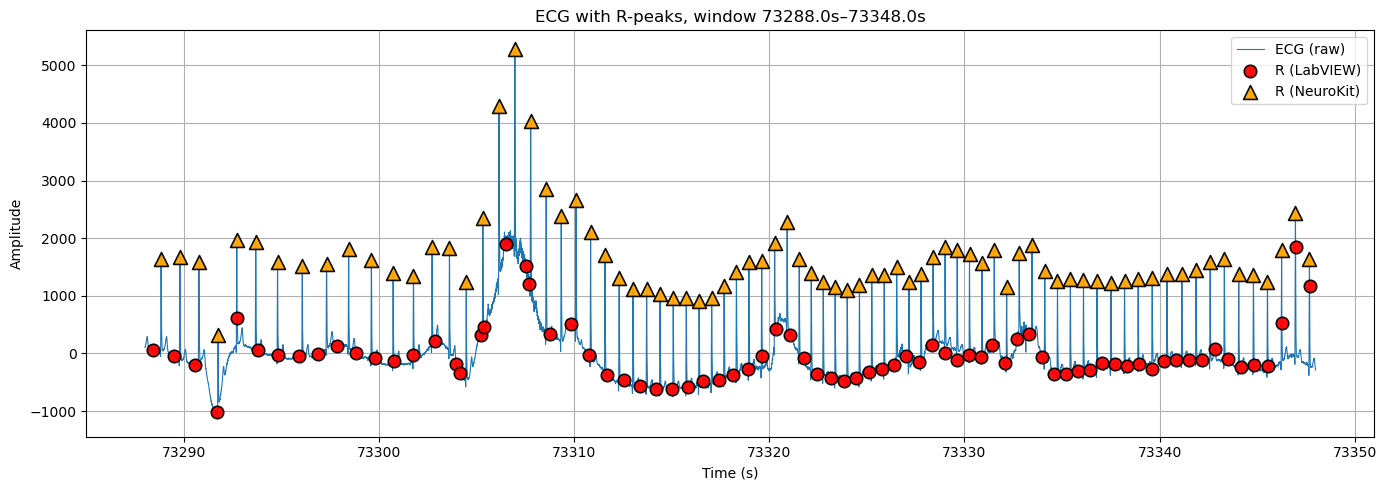


=== SUMMARY ===
TP=14982, FP=152090, FN=171101
Sensitivity=0.0805 | PPV=0.0897 | F1=0.0848



In [45]:
TDMS_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
LABVIEW_LVM_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"
print("Edit TDMS_PATH and LABVIEW_LVM_PATH inside main() before running this script.")

main()

TDMS start (local naive): 2016-10-12 11:05:02
[TDMS] Start time (local): 2016-10-12 11:05:02
[NK] Detected 167188 R-peaks from ECG.
[ALIGN] Estimated offset from headers: 77.182 s (accumulated offset now 77.182 s)
[LAB] Built 186085 LabVIEW peak samples.
[METRICS] {'TP': 14982, 'FP': 152090, 'FN': 171101, 'Sensitivity': 0.08051245949388176, 'PPV': 0.08967391304347826, 'F1': 0.08484659710325494, 'lag_samples': -35, 'tol_samples': 20, 'N_overlap': 82270699, 'lo': 39517, 'hi': 82310216}
[BIN] Built binary trains: lab=(82460288,), nk=(82460288,)


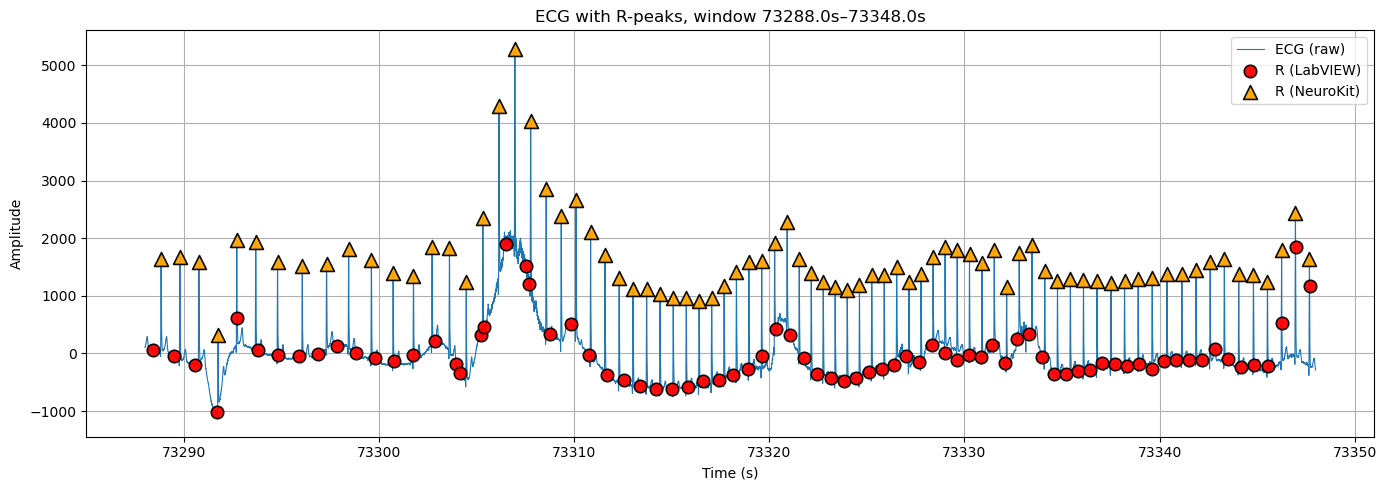


=== SUMMARY ===
TP=14982, FP=152090, FN=171101
Sensitivity=0.0805 | PPV=0.0897 | F1=0.0848

[EVAL] neurokit / (default) -> F1=0.0848, Sens=0.0805, PPV=0.0897
[EVAL] biosppy / (default) -> F1=0.0831, Sens=0.0788, PPV=0.0879
[EVAL] pantompkins1985 / (default) -> F1=0.0845, Sens=0.0801, PPV=0.0895
[EVAL] hamilton / (default) -> F1=0.0836, Sens=0.0792, PPV=0.0886
[EVAL] elgendi / (default) -> F1=0.0841, Sens=0.0798, PPV=0.0889
[EVAL] engzeemod2012 / (default) -> F1=0.0839, Sens=0.0795, PPV=0.0888
[SWEEP] Saved results to: E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results_Excluded_seizures_removed\Results\res.csv

[SWEEP] Top results:
   clean_method peaks_method    TP     FP     FN  Sensitivity      PPV       F1  lag_samples
       neurokit    (default) 14982 152090 171101     0.080512 0.089674 0.084847          -35
pantompkins1985    (default) 14897 151495 171186     0.080056 0.089530 0.084528          -12
        elgendi    (default) 14842 152070 171241     0.079760 0.088921 0

In [48]:
# ============================================================
#        >>>  NeuroKit2 method sweep (add-on)  <<<
# ============================================================
import inspect

def nk_detect_with_methods(signal_1d, fs, method_clean="neurokit", method_peaks=None):
    cleaned = nk.ecg_clean(np.asarray(signal_1d), sampling_rate=int(fs), method=method_clean)
    peaks_kwargs = {"sampling_rate": int(fs)}
    if method_peaks is not None and "method" in inspect.signature(nk.ecg_peaks).parameters:
        peaks_kwargs["method"] = method_peaks
    peaks_dict, _ = nk.ecg_peaks(cleaned, **peaks_kwargs)

    if "ECG_R_Peaks" in peaks_dict and np.ndim(peaks_dict["ECG_R_Peaks"]) == 1:
        binary = np.asarray(peaks_dict["ECG_R_Peaks"], dtype=np.uint8)
        return np.flatnonzero(binary)

    for v in peaks_dict.values():
        try:
            vv = np.asarray(v)
            if vv.ndim == 1 and vv.size == cleaned.size:
                return np.flatnonzero(vv.astype(np.uint8) > 0)
            if vv.ndim == 1 and vv.size < cleaned.size and vv.dtype.kind in ("i", "u"):
                return vv.astype(int)
        except Exception:
            pass
    raise RuntimeError("Could not extract R-peak indices from nk.ecg_peaks output.")

def evaluate_nk_variants(ecg_series, fs, lab_idx, tol_ms=40.0, max_lag_ms=150.0,
                         clean_methods=None, peaks_methods=None, verbose=True):
    if clean_methods is None:
        clean_methods = ["neurokit", "biosppy", "pantompkins1985", "hamilton", "elgendi", "engzeemod2012"]
    if peaks_methods is None:
        peaks_methods = [None]

    rows = []
    for cm in clean_methods:
        for pm in peaks_methods:
            try:
                nk_idx = nk_detect_with_methods(ecg_series.to_numpy(), fs, method_clean=cm, method_peaks=pm)
                m = event_metrics_overlap_lag(lab_idx, nk_idx, fs=fs, tol_ms=tol_ms, max_lag_ms=max_lag_ms)
                rows.append({"clean_method": cm, "peaks_method": pm if pm is not None else "(default)", **m})
                if verbose:
                    print(f"[EVAL] {cm} / {pm or '(default)'} -> F1={m['F1']:.4f}, Sens={m['Sensitivity']:.4f}, PPV={m['PPV']:.4f}")
            except Exception as e:
                rows.append({"clean_method": cm, "peaks_method": pm if pm is not None else "(default)", "error": str(e)})
                if verbose:
                    print(f"[EVAL] {cm} / {pm or '(default)'} -> ERROR: {e}")
    df = pd.DataFrame(rows)
    if "F1" in df.columns:
        df = df.sort_values(by=["F1"], ascending=False, na_position="last").reset_index(drop=True)
    return df

# Run the original pipeline first
ecg, fs, lab_idx, TOL_MS, MAX_LAG_MS = main(return_objects=True)

results = evaluate_nk_variants(
    ecg_series=ecg, fs=fs, lab_idx=lab_idx,
    tol_ms=TOL_MS, max_lag_ms=MAX_LAG_MS,
    clean_methods=["neurokit","biosppy","pantompkins1985","hamilton","elgendi","engzeemod2012"],
    peaks_methods=[None],
    verbose=True
)

out_csv = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results_Excluded_seizures_removed\Results\res.csv"
try:
    results.to_csv(out_csv, index=False)
    print(f"[SWEEP] Saved results to: {out_csv}")
except Exception as e:
    print(f"[SWEEP] Could not save CSV: {e}")

cols = ["clean_method", "peaks_method", "TP", "FP", "FN", "Sensitivity", "PPV", "F1", "lag_samples"]
cols = [c for c in cols if c in results.columns]
print("\n[SWEEP] Top results:")
print(results[cols].head(10).to_string(index=False))


In [50]:
for tol in [20, 30, 40, 60, 80]:
    df = evaluate_nk_variants(ecg, fs, lab_idx, clean_methods=["neurokit"], tol_ms=tol)
    print(f"TOL={tol}ms -> bedste F1={df['F1'].max():.4f}")


[EVAL] neurokit / (default) -> F1=0.0437, Sens=0.0415, PPV=0.0462
TOL=20ms -> bedste F1=0.0437
[EVAL] neurokit / (default) -> F1=0.0638, Sens=0.0605, PPV=0.0674
TOL=30ms -> bedste F1=0.0638
[EVAL] neurokit / (default) -> F1=0.0848, Sens=0.0805, PPV=0.0897
TOL=40ms -> bedste F1=0.0848
[EVAL] neurokit / (default) -> F1=0.1305, Sens=0.1238, PPV=0.1379
TOL=60ms -> bedste F1=0.1305
[EVAL] neurokit / (default) -> F1=0.1715, Sens=0.1628, PPV=0.1813
TOL=80ms -> bedste F1=0.1715


=== BEFORE OFFSET ===
LabVIEW idx: n=186085, min=39517, max=82310251, range=82270734
NeuroKit idx: n=167188, min=949, max=82458253, range=82457304
[INFO] Different number of peaks (186085 vs 167188) — expected.

[OFFSET] Best offset = -100.0000 s (TP in first 77s = 0)

=== AFTER OFFSET ===
LabVIEW idx: n=186085, min=39517, max=82310251
NeuroKit (offset) idx: n=167188, min=-50251, max=82407053
[INFO] Overlap range: 39517–82310251 (160685.03 s, 82270734 samples)
[DEBUG] Binary lengths: lab=82270734, nk=82270734, sum(lab)=186084, sum(nk)=167081
[LAG] Best small lag = +10 samples (~19.5 ms), TP at bestlag in overlap = 442

[OVERLAP METRICS]
Before lag:  TP=15672, FP=151409, FN=170412, F1=0.0888
 After lag:  TP=15714, FP=151367, FN=170369, F1=0.0890


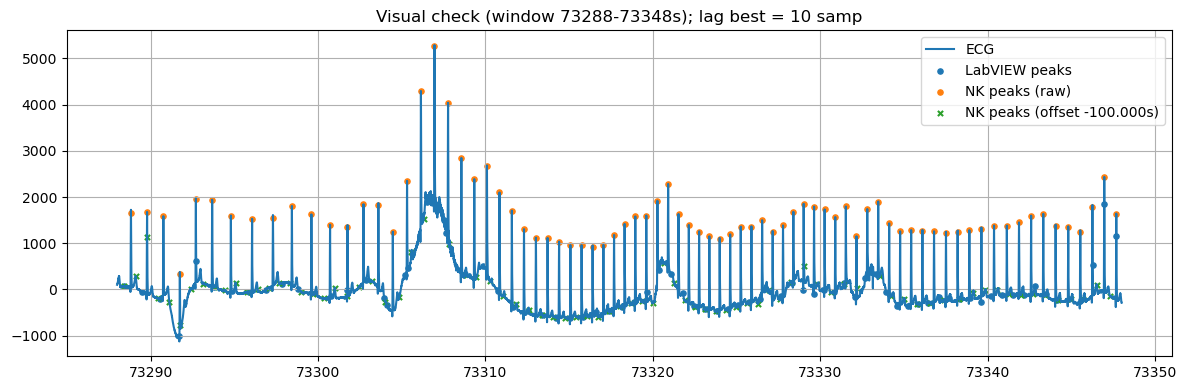

{'best_offset_s': -100.0, 'best_lag_samples': 10, 'before_overlap_metrics': {'TP': 15672, 'FP': 151409, 'FN': 170412, 'Sensitivity': 0.0842200296640227, 'PPV': 0.09379881614306833, 'F1': 0.08875171661971032}, 'after_overlap_metrics': {'TP': 15714, 'FP': 151367, 'FN': 170369, 'Sensitivity': 0.08444618799138019, 'PPV': 0.09405019122461561, 'F1': 0.08898981776171977}, 'offset_scan':        offset_s  TP
0      -100.000   0
1       -99.996   0
2       -99.992   0
3       -99.988   0
4       -99.984   0
...         ...  ..
49997    99.988   0
49998    99.992   0
49999    99.996   0
50000   100.000   0
50001   100.004   0

[50002 rows x 2 columns]}


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Hjælpefunktioner ---

def _count_matches(g_times, t_times, tol_s):
    """Greedy 2-pointer match: hvor mange par (g,t) er inden for tol_s?"""
    i = j = 0
    TP = 0
    while i < len(g_times) and j < len(t_times):
        dt = t_times[j] - g_times[i]
        if abs(dt) <= tol_s:
            TP += 1
            i += 1; j += 1
        elif dt < -tol_s:
            j += 1  # test for tidlig
        else:
            i += 1  # gold for tidlig
    return TP

def find_best_offset_seconds(gold_idx, test_idx, fs, tol_ms=40, search_s=10.0, step_ms=4.0, limit_s=None):
    """
    Find offset (sek) der maksimerer matches (TP) inden for tol_ms.
    - search_s: søger i interval [-search_s, +search_s]
    - step_ms: grid-størrelse for offset-søgningen
    - limit_s: (valgfri) vurder kun de første 'limit_s' sekunder (robust mod drift)
    Returnerer (best_offset_s, best_tp, per_offset_df)
    """
    tol_s = tol_ms/1000.0
    offs = np.arange(-search_s, search_s + step_ms/1000.0, step_ms/1000.0)
    g = np.asarray(gold_idx, int); t = np.asarray(test_idx, int)
    if limit_s is not None:
        g = g[g/fs <= limit_s]
        t = t[t/fs <= limit_s]
    g_times = g / fs

    rows = []
    best_tp, best_off = -1, 0.0
    for off in offs:
        t_times = (t / fs) + off
        tp = _count_matches(g_times, t_times, tol_s)
        rows.append((off, tp))
        if tp > best_tp:
            best_tp, best_off = tp, off
    df = pd.DataFrame(rows, columns=["offset_s","TP"])
    return best_off, best_tp, df.sort_values("offset_s").reset_index(drop=True)

def best_small_lag_samples(gold_bin, test_bin, max_lag_samp):
    """
    Find integer lag i samples der maximerer (gold & test_shifted).sum().
    Returnerer (lag_samples, TP_at_bestlag)
    """
    a = gold_bin.astype(np.uint8); b = test_bin.astype(np.uint8)
    best, bestlag = -1, 0
    for lag in range(-max_lag_samp, max_lag_samp+1):
        if lag < 0:
            score = int((a[:lag] & b[-lag:]).sum())
        elif lag > 0:
            score = int((a[lag:] & b[:-lag]).sum())
        else:
            score = int((a & b).sum())
        if score > best:
            best, bestlag = score, lag
    return bestlag, best

def make_binary(length, idx):
    x = np.zeros(int(length), dtype=np.uint8)
    idx = np.asarray(idx, int)
    idx = idx[(idx >= 0) & (idx < len(x))]
    x[idx] = 1
    return x

# --- “Bevis”-pipen ---

def prove_alignment(ecg, fs, lab_idx, nk_idx, tol_ms=40, offset_search_s=10.0, offset_step_ms=4.0,
                    offset_eval_first_s=60.0, max_lag_ms=150.0, plot_window=(100, 10)):
    """
    To-trins justering:
      1) Grov offset i sek. (maks TP inden for tolerance i de første offset_eval_first_s)
      2) Fin-lag (±max_lag_ms) i samples
    Printer før/efter metrics + returnerer dict m. resultater.
    """
    tol_samp = int(round(tol_ms/1000.0*fs))
    maxlag = int(round(max_lag_ms/1000.0*fs))

    # ---- Før offset ----
    print("=== BEFORE OFFSET ===")
    print(f"LabVIEW idx: n={len(lab_idx)}, min={lab_idx.min()}, max={lab_idx.max()}, range={lab_idx.max()-lab_idx.min()}")
    print(f"NeuroKit idx: n={len(nk_idx)}, min={nk_idx.min()}, max={nk_idx.max()}, range={nk_idx.max()-nk_idx.min()}")
    if len(lab_idx) != len(nk_idx):
        print(f"[INFO] Different number of peaks ({len(lab_idx)} vs {len(nk_idx)}) — expected.\n")

    # 1) Find bedste offset (sek)
    best_off_s, best_off_tp, off_df = find_best_offset_seconds(
        lab_idx, nk_idx, fs, tol_ms=tol_ms, search_s=offset_search_s,
        step_ms=offset_step_ms, limit_s=offset_eval_first_s
    )
    print(f"[OFFSET] Best offset = {best_off_s:+.4f} s (TP in first {offset_eval_first_s:.0f}s = {best_off_tp})")

    # Apply offset
    nk_idx_off = nk_idx + int(round(best_off_s * fs))

    # ---- Efter offset ----
    print("\n=== AFTER OFFSET ===")
    print(f"LabVIEW idx: n={len(lab_idx)}, min={lab_idx.min()}, max={lab_idx.max()}")
    print(f"NeuroKit (offset) idx: n={len(nk_idx_off)}, min={nk_idx_off.min()}, max={nk_idx_off.max()}")
    overlap_start = max(lab_idx.min(), nk_idx_off.min())
    overlap_end   = min(lab_idx.max(), nk_idx_off.max())
    overlap_len   = overlap_end - overlap_start
    print(f"[INFO] Overlap range: {overlap_start}–{overlap_end} ({overlap_len/fs:.2f} s, {overlap_len} samples)")

    if overlap_len <= 0:
        raise ValueError("No temporal overlap after applying offset. Check your data.")

    # Byg binære serier for overlap
    N = int(overlap_len)
    a = make_binary(N, lab_idx[(lab_idx>=overlap_start) & (lab_idx<overlap_end)] - overlap_start)
    b = make_binary(N, nk_idx_off[(nk_idx_off>=overlap_start) & (nk_idx_off<overlap_end)] - overlap_start)
    print(f"[DEBUG] Binary lengths: lab={len(a)}, nk={len(b)}, sum(lab)={a.sum()}, sum(nk)={b.sum()}")

    # 2) Find bedste fin-lag (±max_lag_ms)
    bestlag, tp_at_bestlag = best_small_lag_samples(a, b, max_lag_samp=maxlag)
    print(f"[LAG] Best small lag = {bestlag:+d} samples (~{bestlag/fs*1000:.1f} ms), TP at bestlag in overlap = {tp_at_bestlag}")

    from scipy.signal import convolve
    win = np.ones(2*tol_samp+1, dtype=int)
    def metrics_from_bins(A, B):
        TP = int((convolve(A, win, mode='same') * B > 0).sum())
        FP = int(B.sum() - TP)
        FN = int(A.sum() - TP)
        sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
        ppv  = TP/(TP+FP) if (TP+FP)>0 else np.nan
        f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan
        return dict(TP=TP, FP=FP, FN=FN, Sensitivity=sens, PPV=ppv, F1=f1)

    # Before/after lag metrics
    base_m = metrics_from_bins(a, b)
    if bestlag > 0:
        A2 = a[bestlag:]; B2 = b[:-bestlag]
    elif bestlag < 0:
        A2 = a[:bestlag];  B2 = b[-bestlag:]
    else:
        A2, B2 = a, b
    best_m = metrics_from_bins(A2, B2)

    print("\n[OVERLAP METRICS]")
    print(f"Before lag:  TP={base_m['TP']}, FP={base_m['FP']}, FN={base_m['FN']}, F1={base_m['F1']:.4f}")
    print(f" After lag:  TP={best_m['TP']}, FP={best_m['FP']}, FN={best_m['FN']}, F1={best_m['F1']:.4f}")

    # --- Valgfrit plot ---
    start_s, dur_s = plot_window
    s = int(start_s*fs); e = int((start_s+dur_s)*fs)
    nk_loc  = nk_idx[(nk_idx>=s) & (nk_idx<e)] - s
    nk_off  = nk_idx_off[(nk_idx_off>=s) & (nk_idx_off<e)] - s
    lab_loc = lab_idx[(lab_idx>=s) & (lab_idx<e)] - s

    plt.figure(figsize=(12,4))
    t = np.arange(s,e)/fs
    plt.plot(t, ecg.values[s:e], label="ECG")
    plt.scatter(t[lab_loc], ecg.values[s:e][lab_loc], s=14, label="LabVIEW peaks")
    plt.scatter(t[nk_loc],  ecg.values[s:e][nk_loc],  s=14, label="NK peaks (raw)")
    if len(nk_off):
        plt.scatter(t[nk_off], ecg.values[s:e][nk_off], s=14, marker='x', label=f"NK peaks (offset {best_off_s:+.3f}s)")
    plt.title(f"Visual check (window {start_s}-{start_s+dur_s}s); lag best = {bestlag} samp")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return {
        "best_offset_s": best_off_s,
        "best_lag_samples": int(bestlag),
        "before_overlap_metrics": base_m,
        "after_overlap_metrics": best_m,
        "offset_scan": off_df
    }


# Ensure nk_idx exists (try to detect peaks automatically if not provided)
if 'nk_idx' not in globals():
    try:
        detected = detect_ecg_peaks(ecg, fs)
        # detect_ecg_peaks may return an array-like or a dict with 'peaks'
        if isinstance(detected, dict) and 'peaks' in detected:
            nk_idx = np.asarray(detected['peaks'], int)
        else:
            nk_idx = np.asarray(detected, int)
        print(f"[INFO] nk_idx was not present; detected {len(nk_idx)} NK peaks automatically.")
    except Exception as e:
        raise NameError("nk_idx is not defined and automatic peak detection failed.") from e

res = prove_alignment(
    ecg=ecg, fs=fs,
    lab_idx=lab_idx,
    nk_idx=nk_idx,                          # dine NK R-peak samples
    tol_ms=TOL_MS,                          # brug global konstant hvis tilgængelig
    offset_search_s=100.0,                   # søg +/-100s grov offset
    offset_step_ms=4.0,                     # 4 ms grid
    offset_eval_first_s=77.0,               # find offset på de første 77s (robust)
    max_lag_ms=MAX_LAG_MS,                  # fin-lag ±MAX_LAG_MS
    plot_window=(73288, 60)                   # lille plot for visuel sanity
)
print(res)

In [61]:
import numpy as np
import pandas as pd

def _count_matches(g_idx, t_idx, fs, offset_s, tol_ms=40.0, limit_first_s=None):
    tol_s = tol_ms / 1000.0
    g = np.asarray(g_idx, int)
    t = np.asarray(t_idx, int) + int(round(offset_s * fs))
    if limit_first_s is not None:
        g = g[g/fs <= limit_first_s]
        t = t[t/fs <= limit_first_s]
    gt = g / fs
    tt = t / fs
    i = j = 0; TP = 0
    while i < len(gt) and j < len(tt):
        dt = tt[j] - gt[i]
        if abs(dt) <= tol_s:
            TP += 1; i += 1; j += 1
        elif dt < -tol_s:
            j += 1
        else:
            i += 1
    return TP

def compute_header_refined_offset(
    tdms_start_dt, lab_header_dt, fs, lab_idx, nk_idx,
    *,
    assume_lab_header_is_local=True,
    base_subtract_s=0.0,          # fx 60.0 hvis du VED der er klippet 60 s i starten i LabVIEW
    refine_half_range_s=30.0,
    refine_step_ms=4.0,
    refine_first_s=15*60.0,
    tol_ms=40.0
):
    """
    Returnerer (best_offset_s, df_offsets). Offset-fortegn:
    +offset_s betyder "skub NeuroKit-peaks SENERE (til højre)".
    """
    # 1) Base offset fra headere
    # Hvis lab_header_dt er i lokal tid og tdms_start_dt er i lokal tid, så er differencen direkte:
    base_offset_s = (lab_header_dt - tdms_start_dt).total_seconds() - float(base_subtract_s)

    # 2) Fin-sweep omkring base
    step_s = refine_step_ms / 1000.0
    offs = np.arange(base_offset_s - refine_half_range_s,
                     base_offset_s + refine_half_range_s + step_s, step_s)
    rows = []
    for off in offs:
        tp = _count_matches(lab_idx, nk_idx, fs, off, tol_ms=tol_ms, limit_first_s=refine_first_s)
        rows.append((off, tp))
    df = pd.DataFrame(rows, columns=["offset_s", "TP"]).sort_values("offset_s").reset_index(drop=True)
    best_row = df.iloc[df["TP"].argmax()]
    best_off = float(best_row["offset_s"])
    return best_off, df


In [62]:
# Antag disse findes på dette tidspunkt:
# ecg (Series), fs (float), nk_idx (np.ndarray), lab_idx (np.ndarray)
# tdms_start_dt (datetime), lab_header_dt (datetime)

# Hvis du ved at LabVIEW har fjernet 60 s i starten, sæt base_subtract_s=60.0
best_off_s, df_offsets = compute_header_refined_offset(
    tdms_start_dt, lab_header_dt, fs, lab_idx, nk_idx,
    base_subtract_s=60.0,      # <- sæt 0.0 hvis du IKKE vil kompensere for klip i starten
    refine_half_range_s=30.0,  # ±30 s omkring header-baseret offset
    refine_step_ms=4.0,
    refine_first_s=15*60.0,
    tol_ms=40.0
)
print(f"[OFFSET] Header-based refined offset = {best_off_s:+.3f} s")

# Anvend offset på NK-peaks
nk_idx_off = nk_idx + int(round(best_off_s * fs))

# Kør din eksisterende eval/lag/metrics — fx:
metrics = event_metrics_overlap_lag(lab_idx, nk_idx_off, fs=fs, tol_ms=40.0, max_lag_ms=150.0)
print("[METRICS after header-refined offset]", metrics)

# Valgfrit: kør din prove_alignment men giv nk_idx_off med,
# eller lav en version der springer "offset-søgning" over og kun finder "lag".
res = prove_alignment(
    ecg=ecg, fs=fs,
    lab_idx=lab_idx,
    nk_idx=nk_idx_off,          # <- allerede offsettet
    tol_ms=40,
    offset_search_s=0.0,        # <- undgå ny grovsøgning
    offset_step_ms=4.0,
    offset_eval_first_s=60.0,
    max_lag_ms=150.0,
    plot_window=(100, 10)
)


NameError: name 'tdms_start_dt' is not defined